<a href="https://colab.research.google.com/github/kim-bo-saeng/dacon_jeju/blob/master/jeju_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브에 있는 파일을 구글코랩에서 사용하기 위한 라이브러리 실행
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 라이브러리 가져오기

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 구글코랩에서 한글폰트 설정 및 버전확인

In [ ]:
# 한글폰트 설정(셀 실행후 런타임 다시시작을 하여 해당셀을 다시한번 실행해주어야 제대로 한글이 그래프에 나옴)

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
plt.rc('font', family='NanumBarunGothic') 

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 버전확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sk.__version__))
!python --version



Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
Python 3.6.9


### 데이터 전처리

In [ ]:
# 2019년1월부터 2020년3월 데이터 파일 불러오기
row_data_201901_202003 = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/201901-202003.csv')
print(row_data_201901_202003 .shape)
row_data_201901_202003 .tail()

(24697792, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6
24697791,202003,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3


In [ ]:
# 2020년 4월 데이터 파일 불러오기
row_data_202004 = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/202004.csv')
print(row_data_202004.shape)
row_data_202004.tail()

(1350322, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7
1350321,202004,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4


In [ ]:
# 2019년 1월부터 2020년 3월까지의 데이터와 2020년4월 데이터 합치기
row_data = pd.concat([row_data_201901_202003,row_data_202004]).reset_index(drop = True)
print(row_data.shape)
row_data.tail()

(26048114, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
26048109,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
26048110,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
26048111,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
26048112,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7
26048113,202004,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4


In [ ]:
# 빈값찾기
row_data.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      92371
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      155234
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

In [ ]:
# CARD_CCG_NM / HOM_CCG_NM 모두 세종시일경우 CARD_CCG_NM / HOM_CCG_NM 의 값이 빈값이므로 세종으로 채워줌
print(row_data[row_data['CARD_CCG_NM'].isna()]['CARD_SIDO_NM'].value_counts())
print(row_data[row_data['HOM_CCG_NM'].isna()]['HOM_SIDO_NM'].value_counts())

row_data = row_data.fillna('세종')
row_data.isnull().sum()

세종    92371
Name: CARD_SIDO_NM, dtype: int64
세종    155234
Name: HOM_SIDO_NM, dtype: int64


REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

### EDA

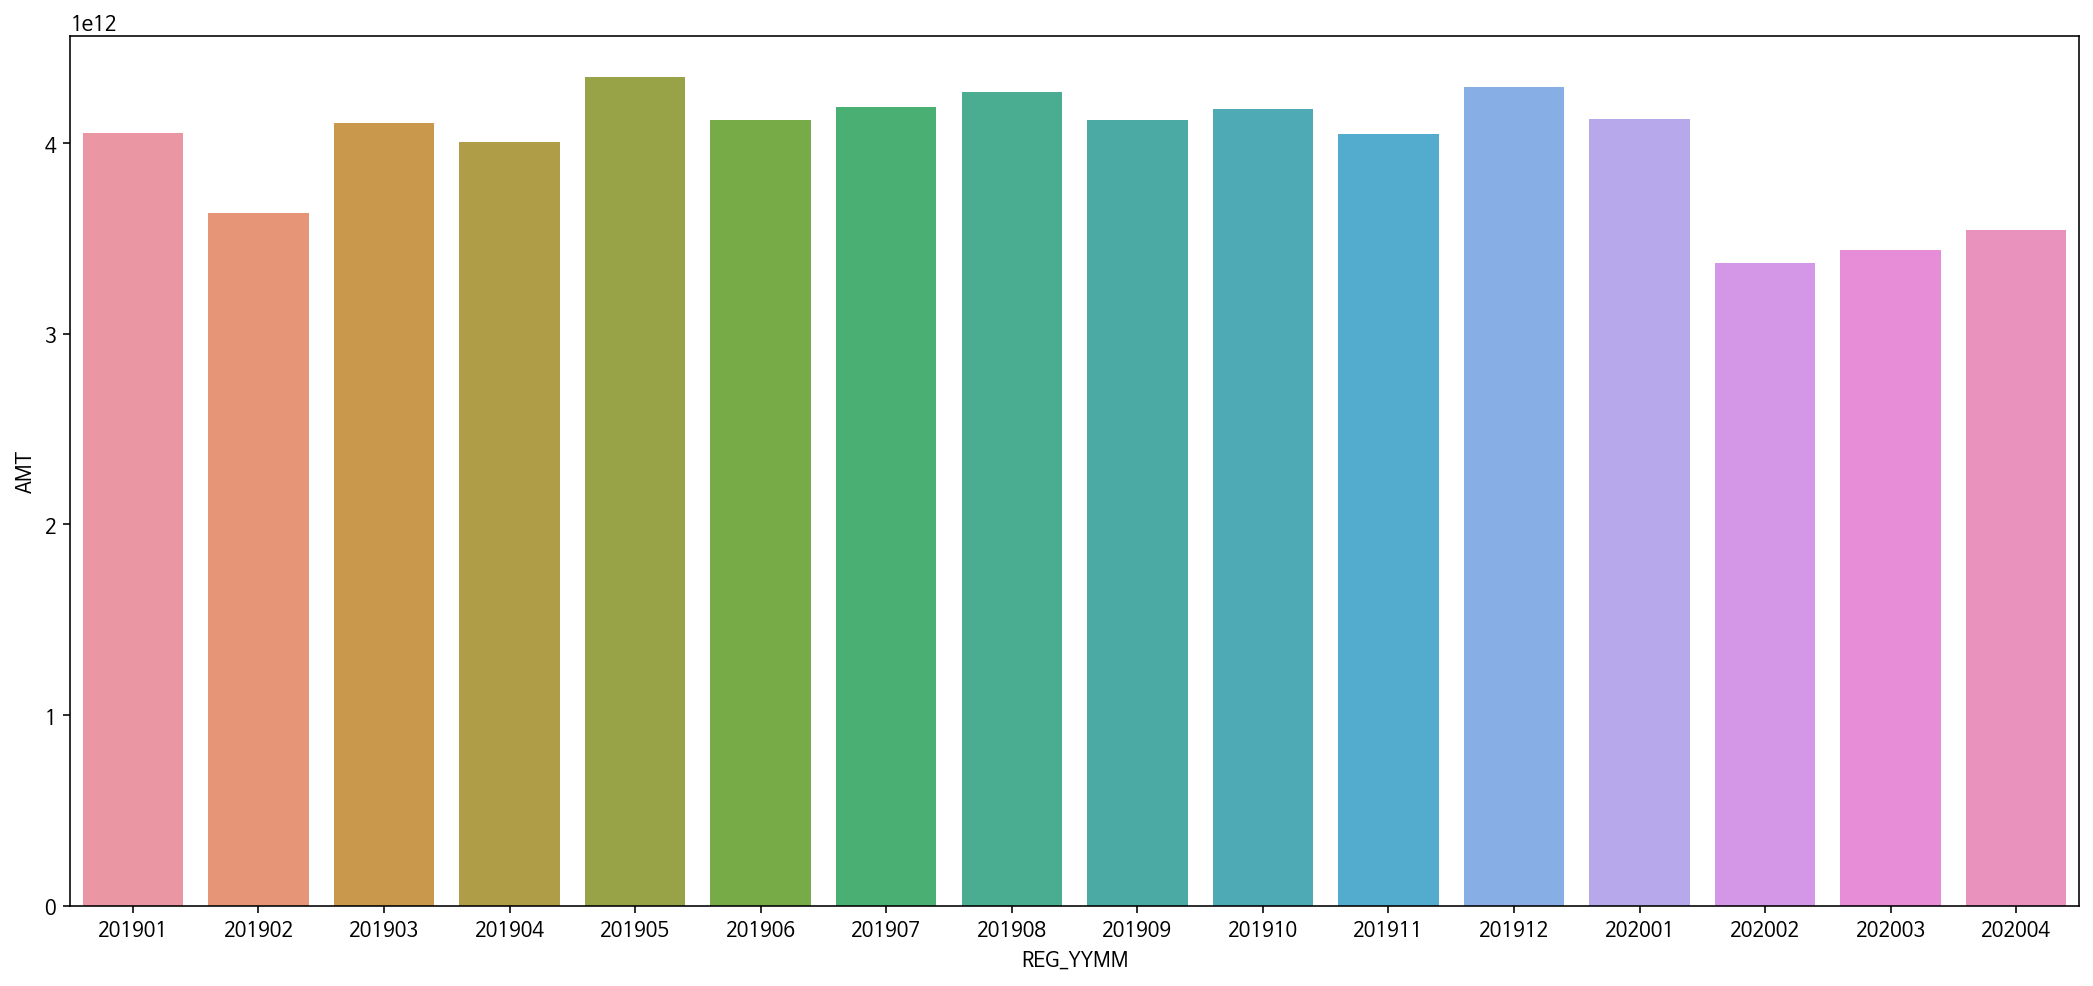

In [ ]:
# 2019년1월 ~ 2020년4월까지 AMT 총량 변화량 살펴보기
YYMM_AMT_data = pd.DataFrame(row_data.groupby(['REG_YYMM'])['AMT'].sum()).reset_index()
plt.figure(figsize=(18,8))
sns.barplot(data = YYMM_AMT_data, x = 'REG_YYMM', y = 'AMT')

- AMT 총량 그래프에서 가장 눈여겨 봐야될 부분은 2020년 1월,2월,3월,4월이다
- 2020년1월은 전년에 비해 매출이 증가했다 -> 코로나의 영향이 없었을 경우의 상황
- 2020년2월은 전년에 비해 매출이 조금 감소했다 -> 코로나의 영향을 2월 중순이후 부터 받기 시작했다
- 2020년3월은 전년에 비해 매출이 많이 감소했다 -> 코로나의 영향을 직격으로 받았다
- 2020년4월은 전년이 비해 매출이 감소하였지만 동년 3월에 비해 조금 높다 -> 코로나 확진자가 4월초가 지나면서 감소한 영향으로 추정
- 따라서 2019년 1월/2월/3월/4월/7월 과 2020년 1월/2월/3월/4월을 이용하여 모델 학습을 진행한다면 코로나의 영향이 반영된 모델 학습이 이루어질것으로 예상
단, 2020년1월은 코로나의 영향이 없는 달이지만 최종적으로 예측할 7월의 경우 코로나의 영향이 2,3,4월에 비해 줄어들것을 감안하여 코로나의 영향이 없는 1월 매출까지 같이 모델이 학습 시켜준다면 7월을 적절히 예측할것으로 예상함

In [ ]:
# 이번에는 2019년 1월/2월/3월/4월 + 2020년 1월/2월/3월/4월 만의 데이터를 이용하여
# 연/월별 업종,카드사용지역,거주지역,연령,성별,생애주기에 따른 차이를 그래프로 확인해보기 위해
# row_data에서 2019년 1월/2월/3월/4월 + 2020년 1월/2월/3월/4월 골라낸뒤 연월/업종/카드사용지역/거주지역/연령/성별/생애주기 별로 그룹화 하여 데이터를 생성함  
row_data_01_04 = row_data[(row_data['REG_YYMM'] == 201901) | (row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201903) | (row_data['REG_YYMM'] == 201904) |
                          (row_data['REG_YYMM'] == 202001) | (row_data['REG_YYMM'] == 202002) | (row_data['REG_YYMM'] == 202003) | (row_data['REG_YYMM'] == 202004)]
row_data_01_04 = row_data_01_04.groupby(['REG_YYMM', 'STD_CLSS_NM','CARD_SIDO_NM', 'HOM_SIDO_NM','AGE', 'SEX_CTGO_CD','FLC'])['AMT'].sum().reset_index()
row_data_01_04

,REG_YYMM,STD_CLSS_NM,CARD_SIDO_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,건강보조식품 소매업,강원,강원,20s,1,1,311200
1,201901,건강보조식품 소매업,강원,강원,30s,1,2,5169295
2,201901,건강보조식품 소매업,강원,강원,30s,2,2,8618550
3,201901,건강보조식품 소매업,강원,강원,40s,1,2,454420
4,201901,건강보조식품 소매업,강원,강원,40s,1,3,6441165
...,...,...,...,...,...,...,...,...
527832,202004,휴양콘도 운영업,충북,충북,30s,2,2,28000
527833,202004,휴양콘도 운영업,충북,충북,40s,1,3,218850
527834,202004,휴양콘도 운영업,충북,충북,40s,2,3,193000
527835,202004,휴양콘도 운영업,충북,충북,50s,1,4,720500


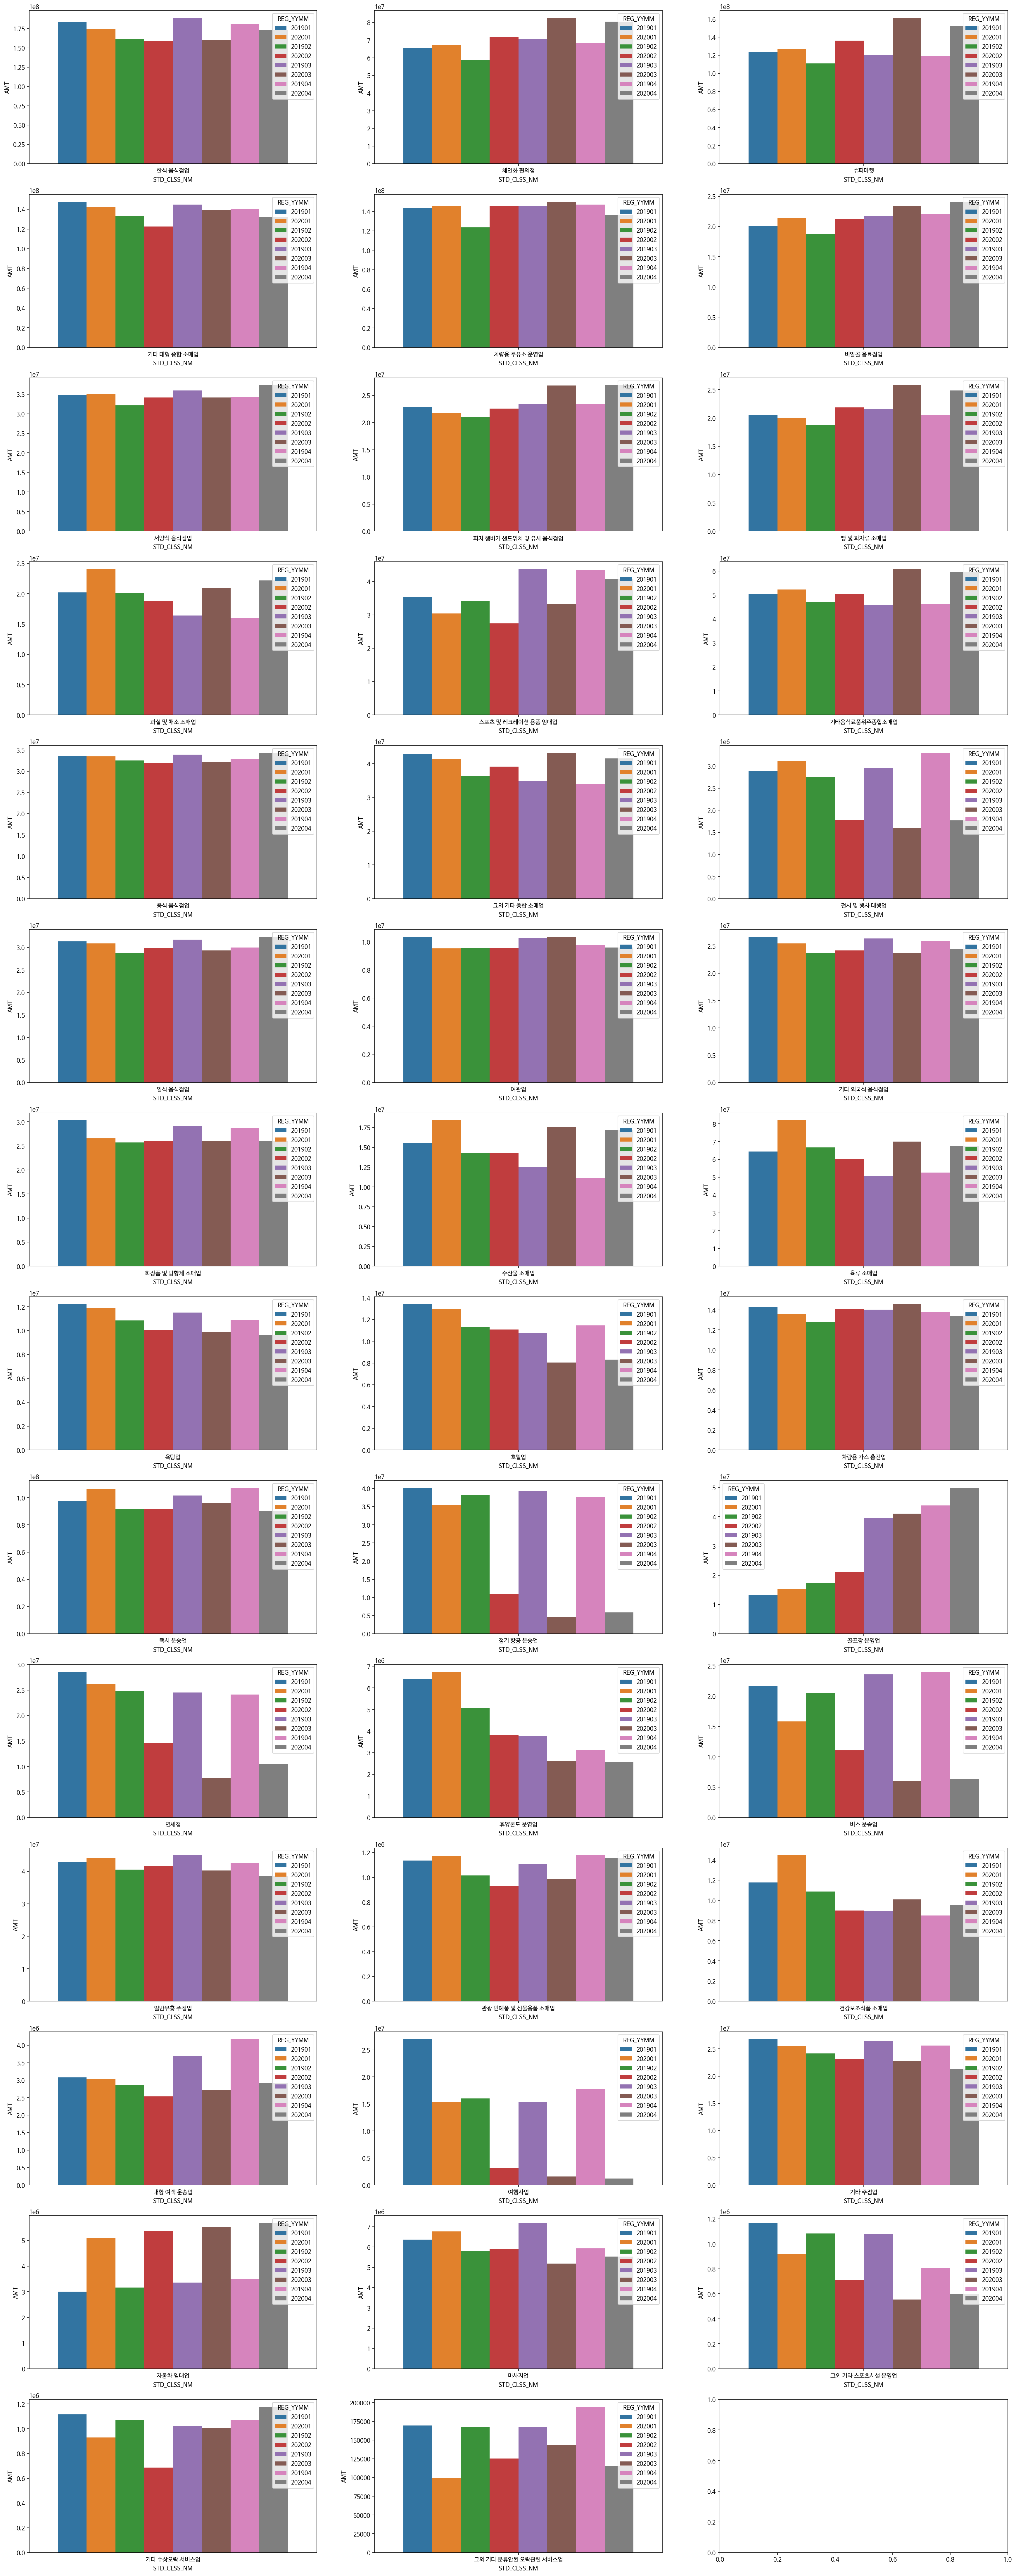

In [ ]:
# 1. 업종별 총매출 차이
sectors = row_data_01_04['STD_CLSS_NM'].value_counts().index

fig , axes = plt.subplots(14,3)
axx = axes.flatten()
fig.set_size_inches(30,80)
i = 0

for sector in sectors:
  plot_data = row_data_01_04[row_data_01_04['STD_CLSS_NM'] == sector]
  sns.barplot(data = plot_data, x = 'STD_CLSS_NM', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004],ci = None, ax = axx[i])
  i += 1

- 업종별 매출에서 차이에서는 코로나의 영향으로 매출이 줄어든것과 늘어난것이 확실히 차이가 발생되는것을 볼 수 있다
- 이것을 모델에 학습 시킬때 1월처럼 영향이 없는 달과 2,3,4월 처럼 영향을 조금 받거나 회복되는 모습이 나타나는 달을 학습 시킨다면 적절한 수준으로 7월 AMT 예측이 가능할것으로 보인다 

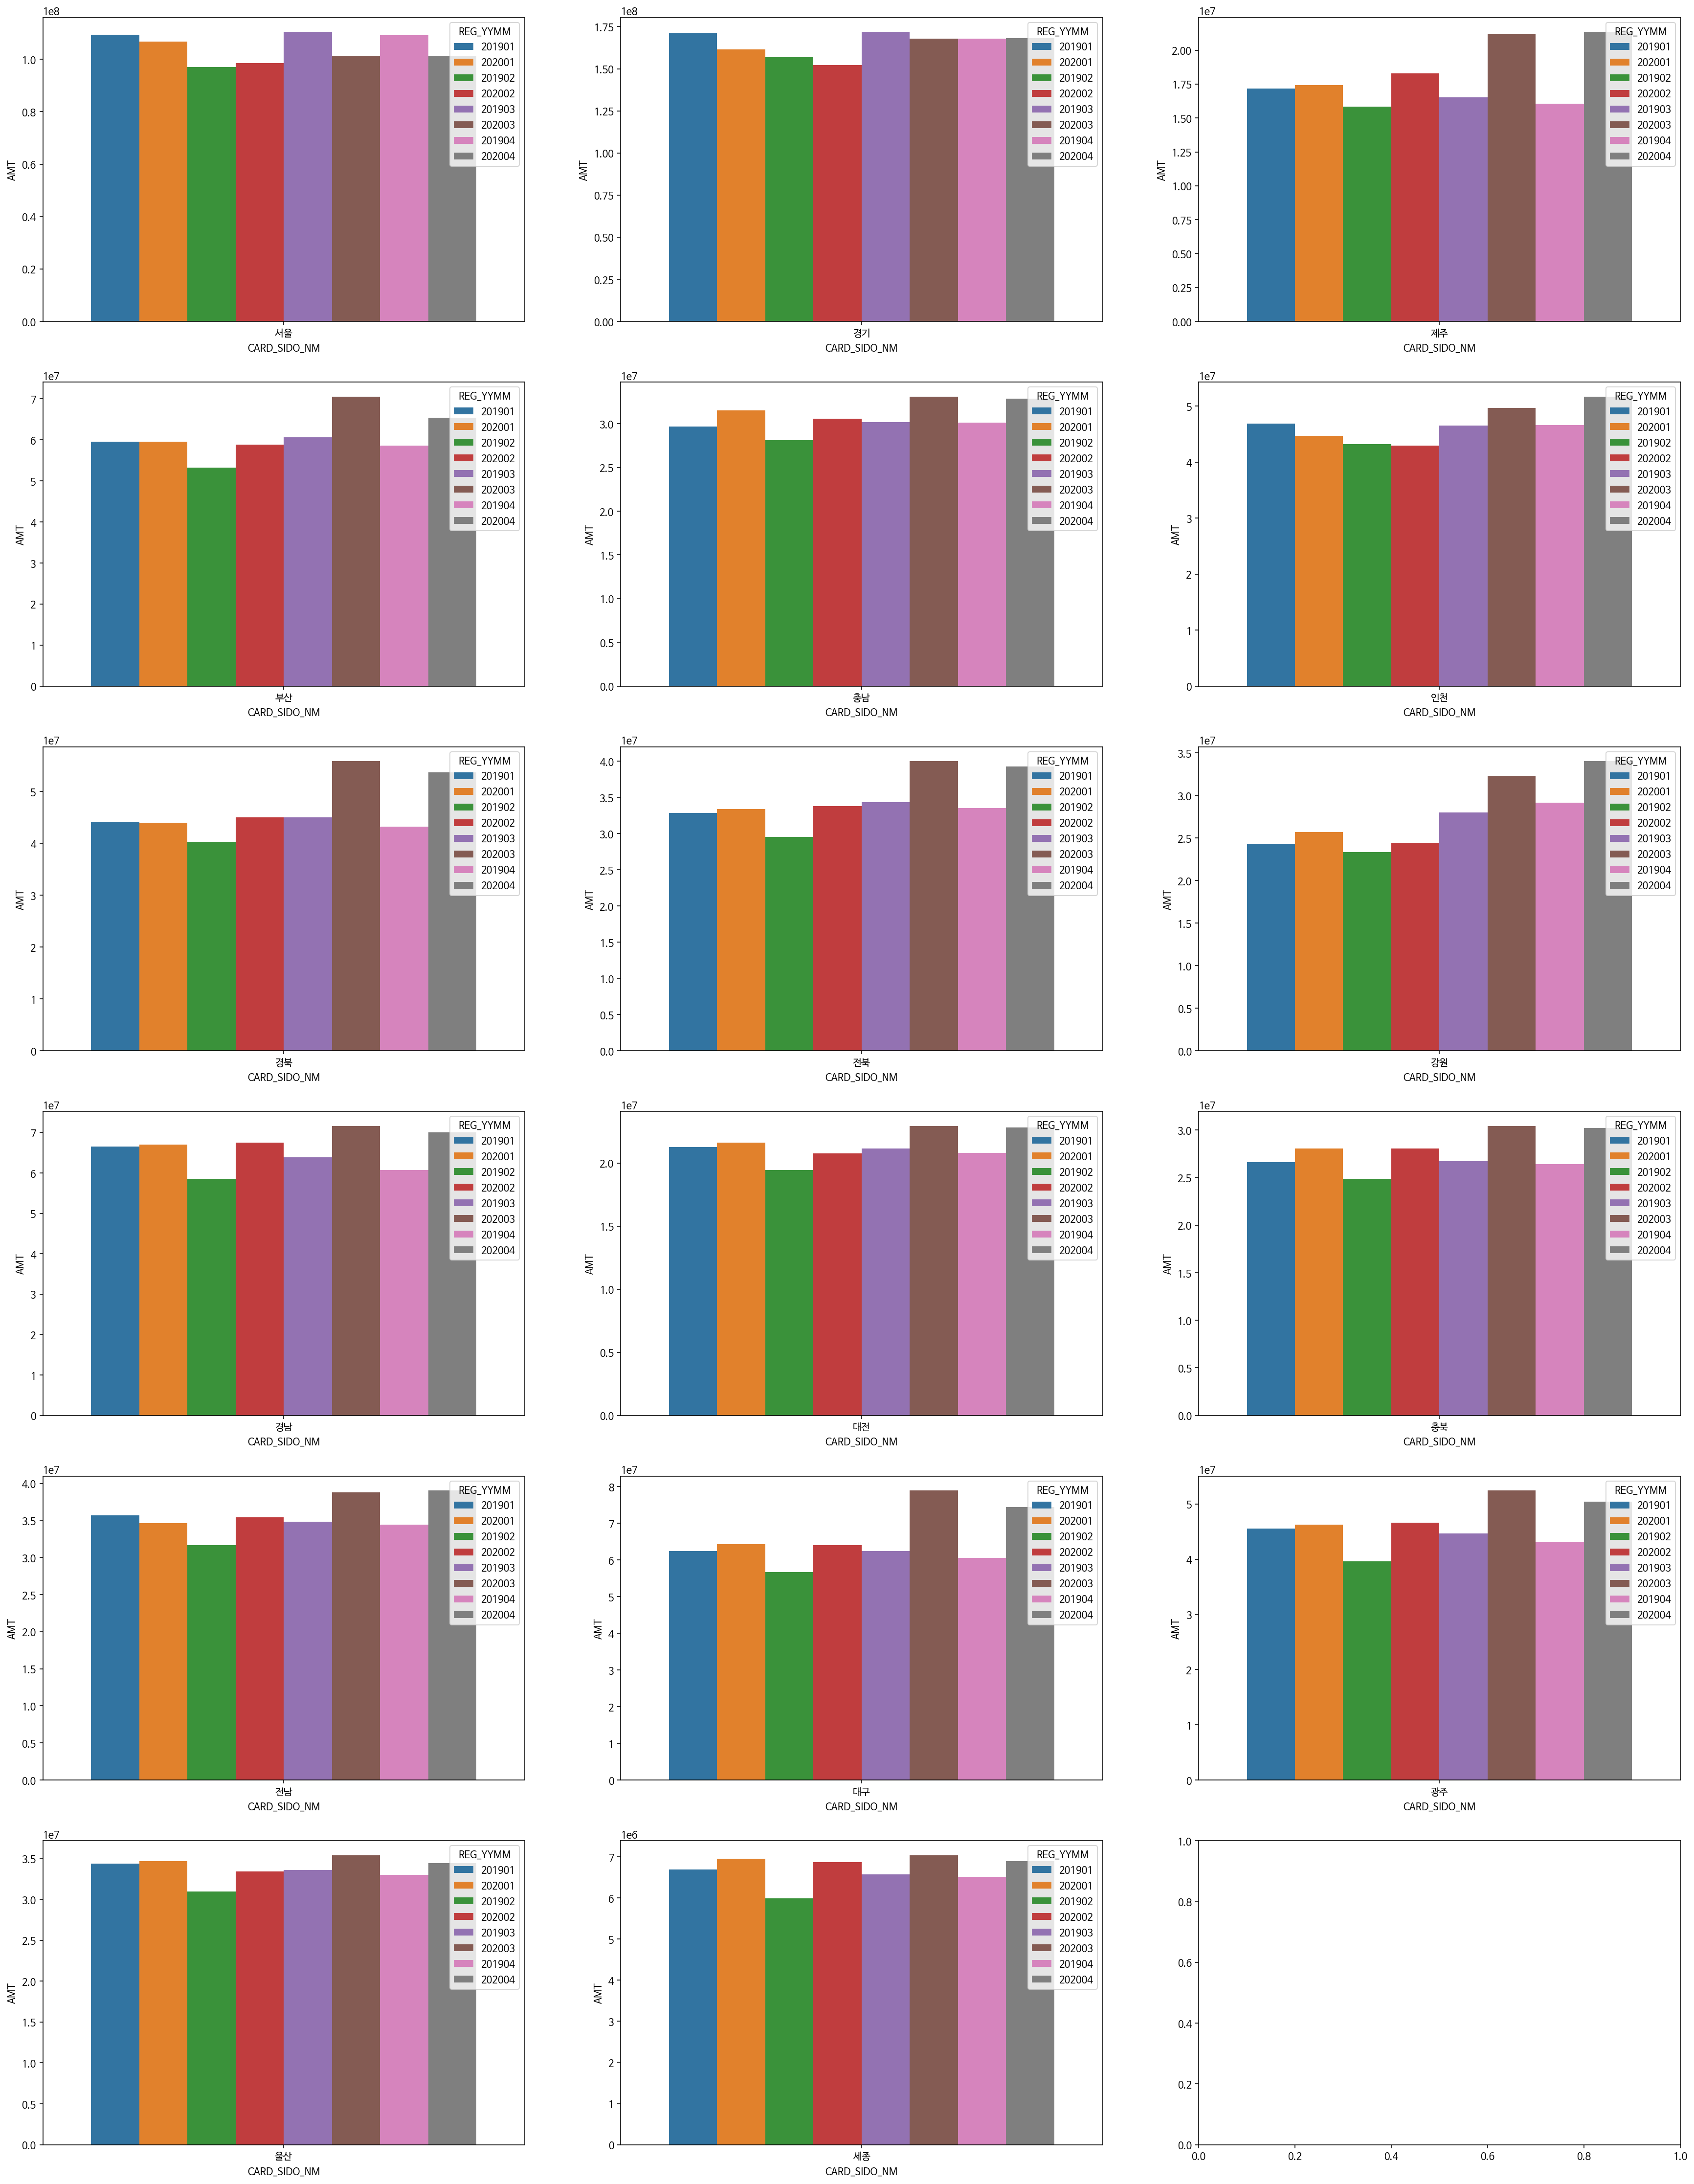

In [ ]:
# 2. 카드사용지역별 총매출 차이
card_sidos = row_data_01_04['CARD_SIDO_NM'].value_counts().index

fig , axes = plt.subplots(6,3)
axx = axes.flatten()
fig.set_size_inches(30,40)
i = 0

for card_sido in card_sidos:
  plot_data = row_data_01_04[row_data_01_04['CARD_SIDO_NM'] == card_sido]
  sns.barplot(data = plot_data, x = 'CARD_SIDO_NM', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004],ci = None, ax = axx[i])
  i += 1

- 서울/경기 지역을 제외하면 3/4월 매출이 전년에 비해 오른것을 볼 수 있고 특히 제주지역은 가장 많은 매출 차이를 보인다
- 이것 또한 모델학습시 필요한 피쳐로 판단된다

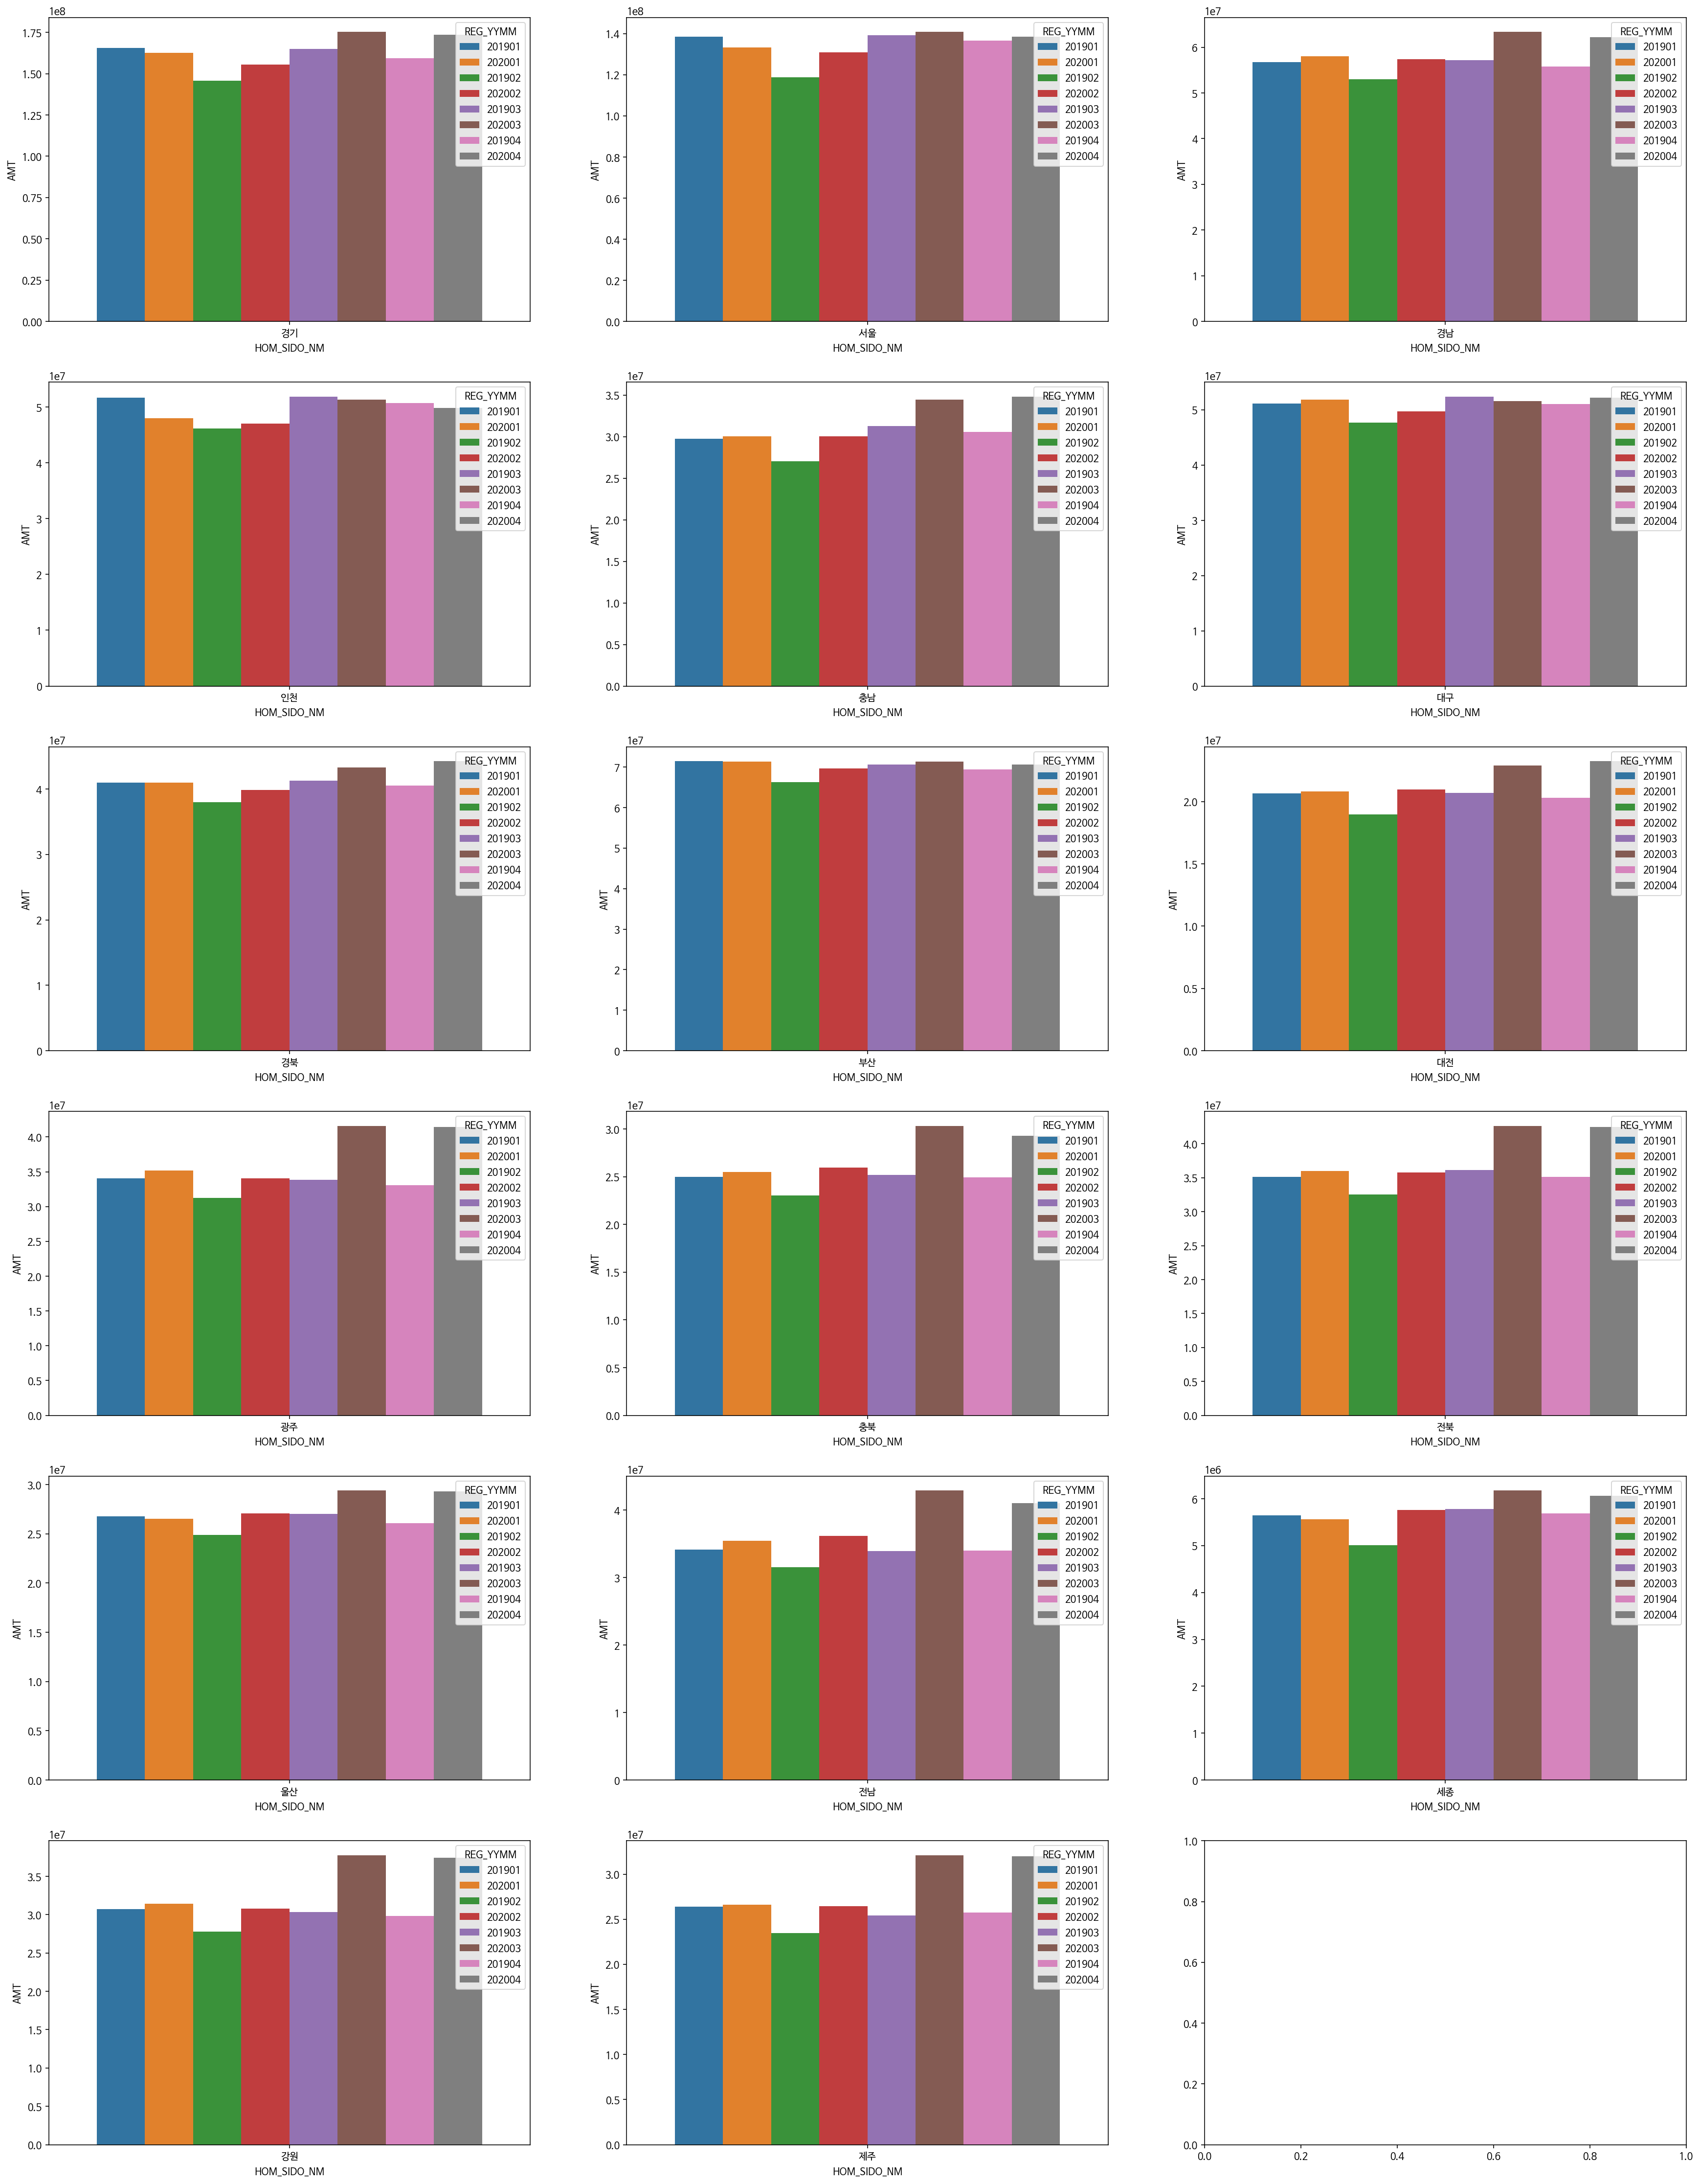

In [ ]:
# 3. 거주지역별 총매출 차이
hom_sidos = row_data_01_04['HOM_SIDO_NM'].value_counts().index

fig , axes = plt.subplots(6,3)
axx = axes.flatten()
fig.set_size_inches(30,40)
i = 0

for hom_sido in hom_sidos:
  plot_data = row_data_01_04[row_data_01_04['HOM_SIDO_NM'] == hom_sido]
  sns.barplot(data = plot_data, x = 'HOM_SIDO_NM', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004],ci = None, ax = axx[i])
  i += 1

- 거주지역별 매출 차이도 대체로 3/4월 매출이 전년에 비해 높다
- 이것또한 모델학습에 필요한 피쳐로 판단된다

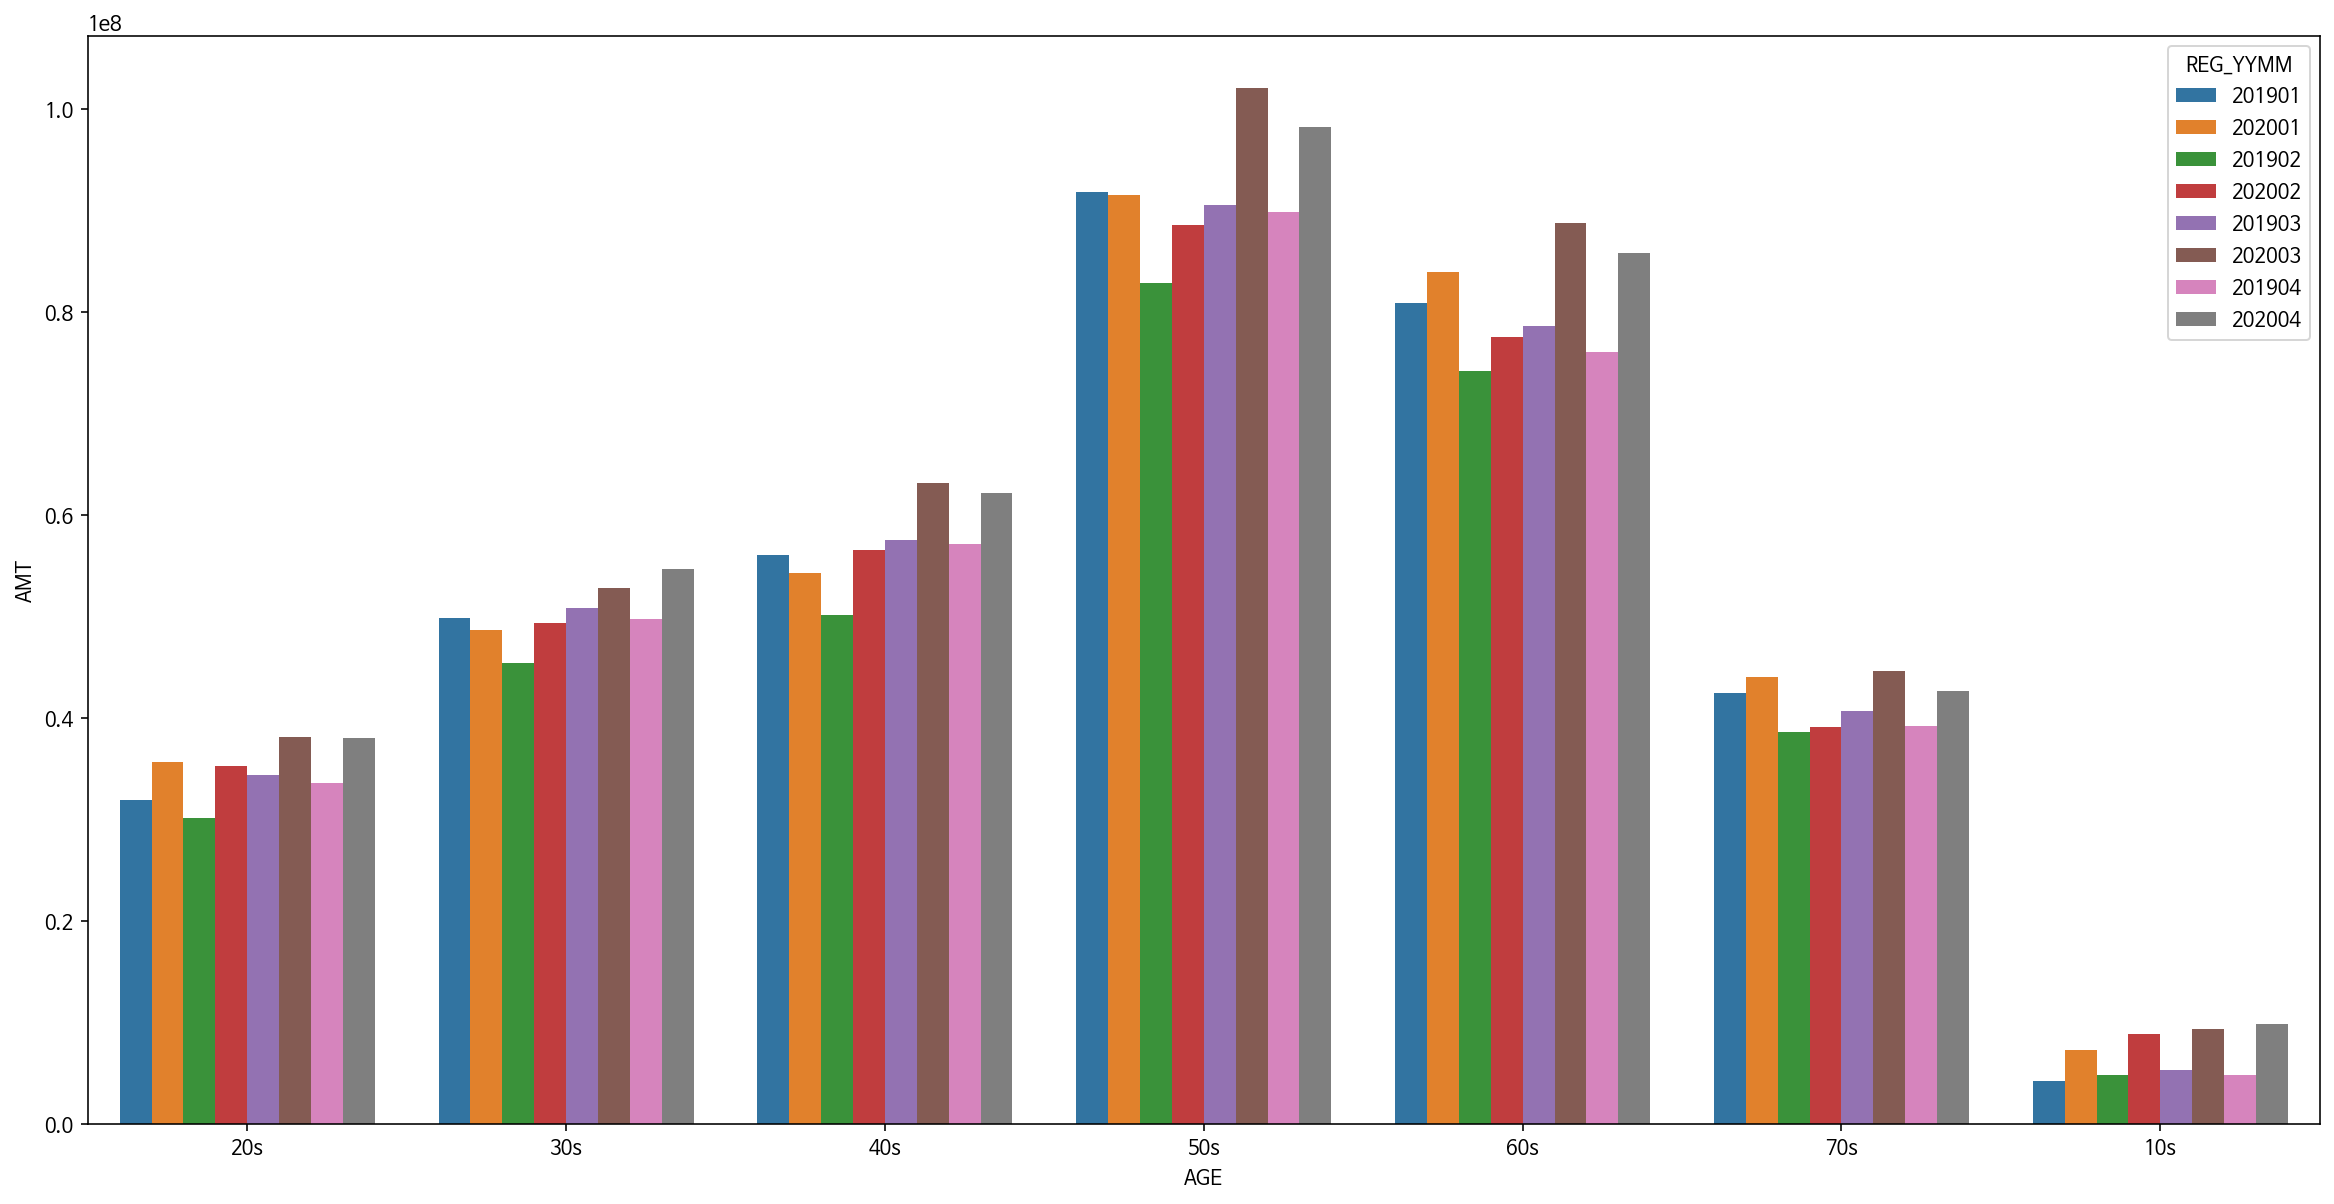

In [ ]:
# 4. 연령별 총매출 차이
plt.figure(figsize=(20,10))
sns.barplot(data = row_data_01_04, x = 'AGE', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004], ci = None)

- 연령 데이터를 보게 되면 3/4월이 전년에 비해 매출이 올랐으며 40대를 제외하고 2020년 3월 대비 4월 매출이 더 낮았다
- 모델학습에서 필요한 피쳐로 판단됨

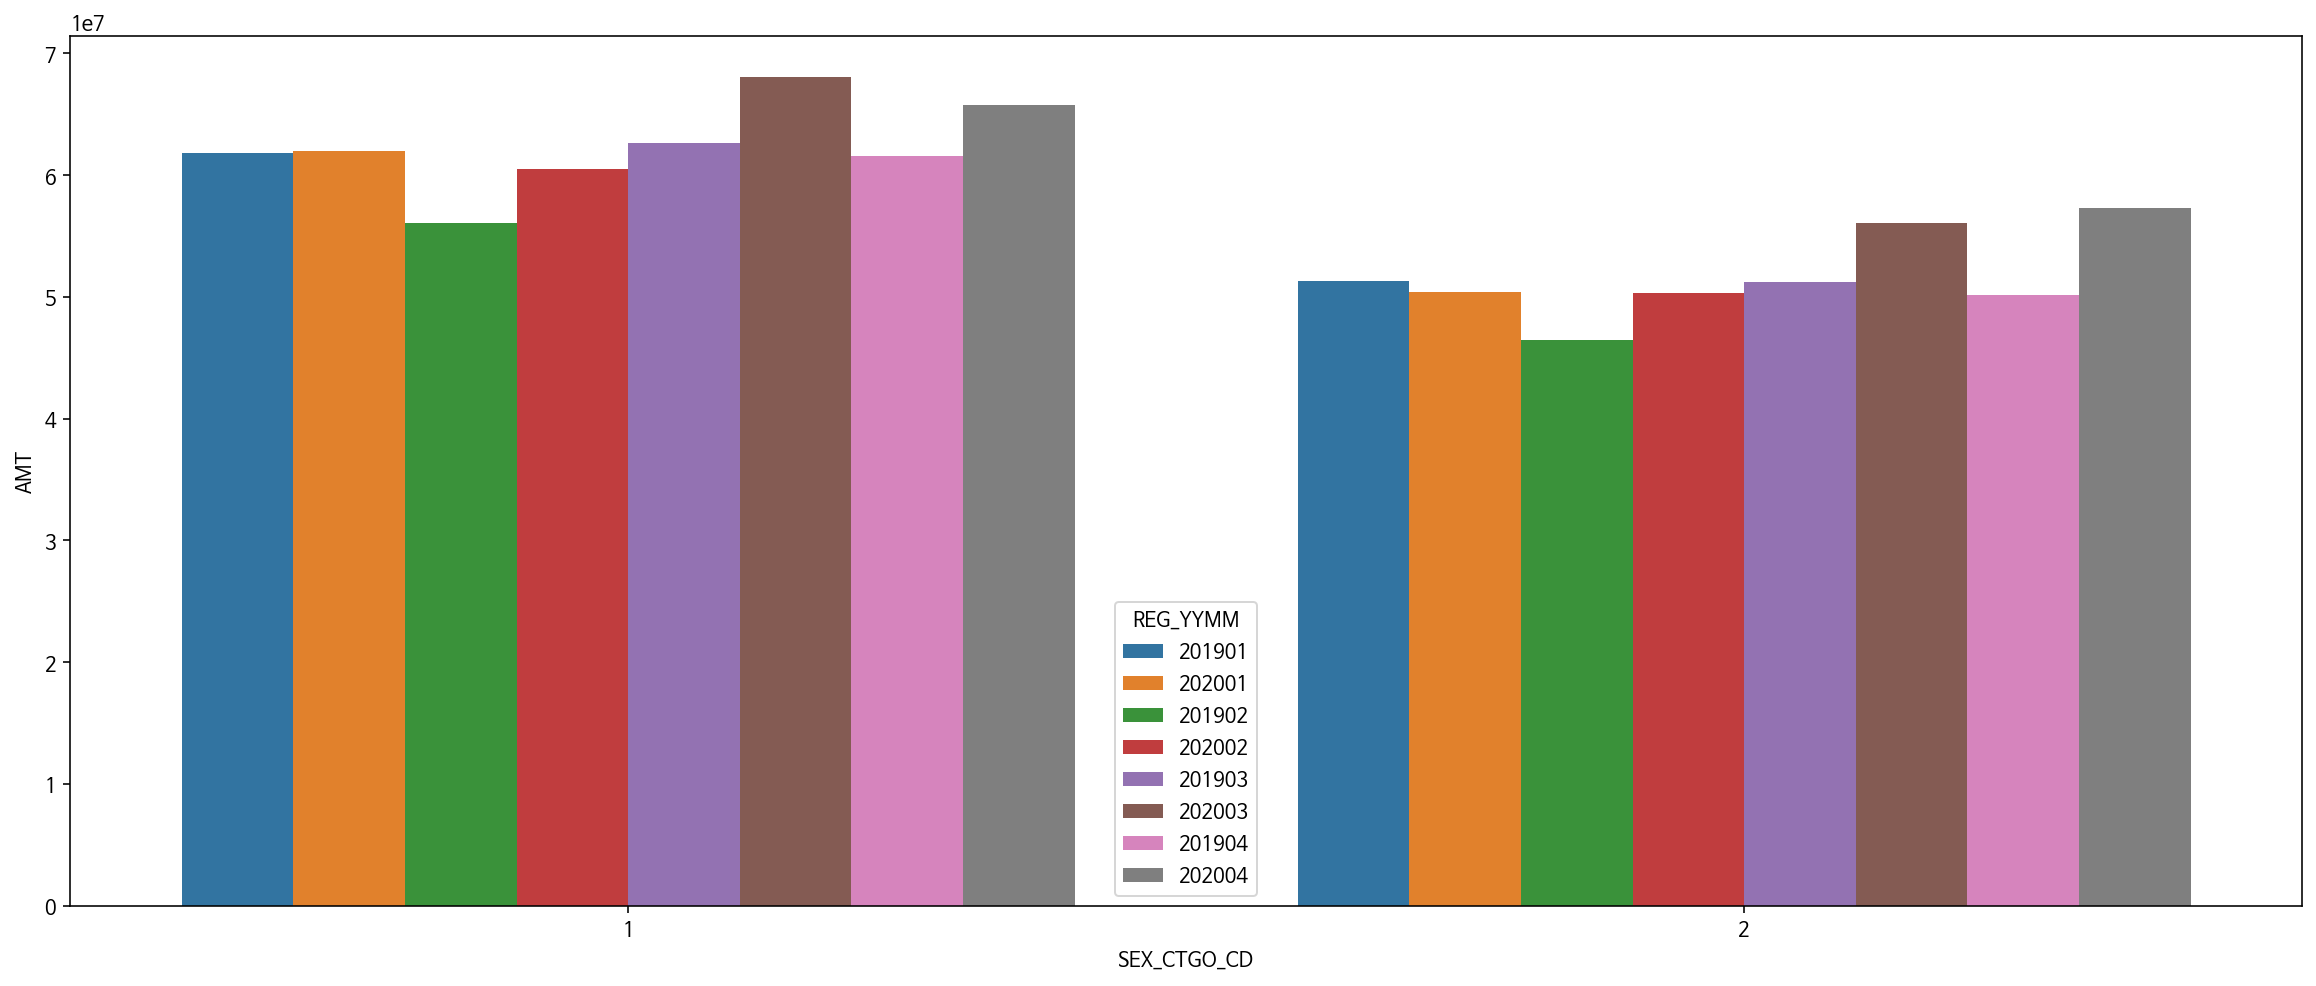

In [ ]:
# 5. 성별별 총매출 차이
plt.figure(figsize=(20,8))
sns.barplot(data = row_data_01_04, x = 'SEX_CTGO_CD', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004], ci = None)

- 성별에서는 남녀가 비슷한 모습이긴하나 2020년 3/4월 매출 추이가 다름
- 모델 학습에 필요한 피쳐로 판단됨

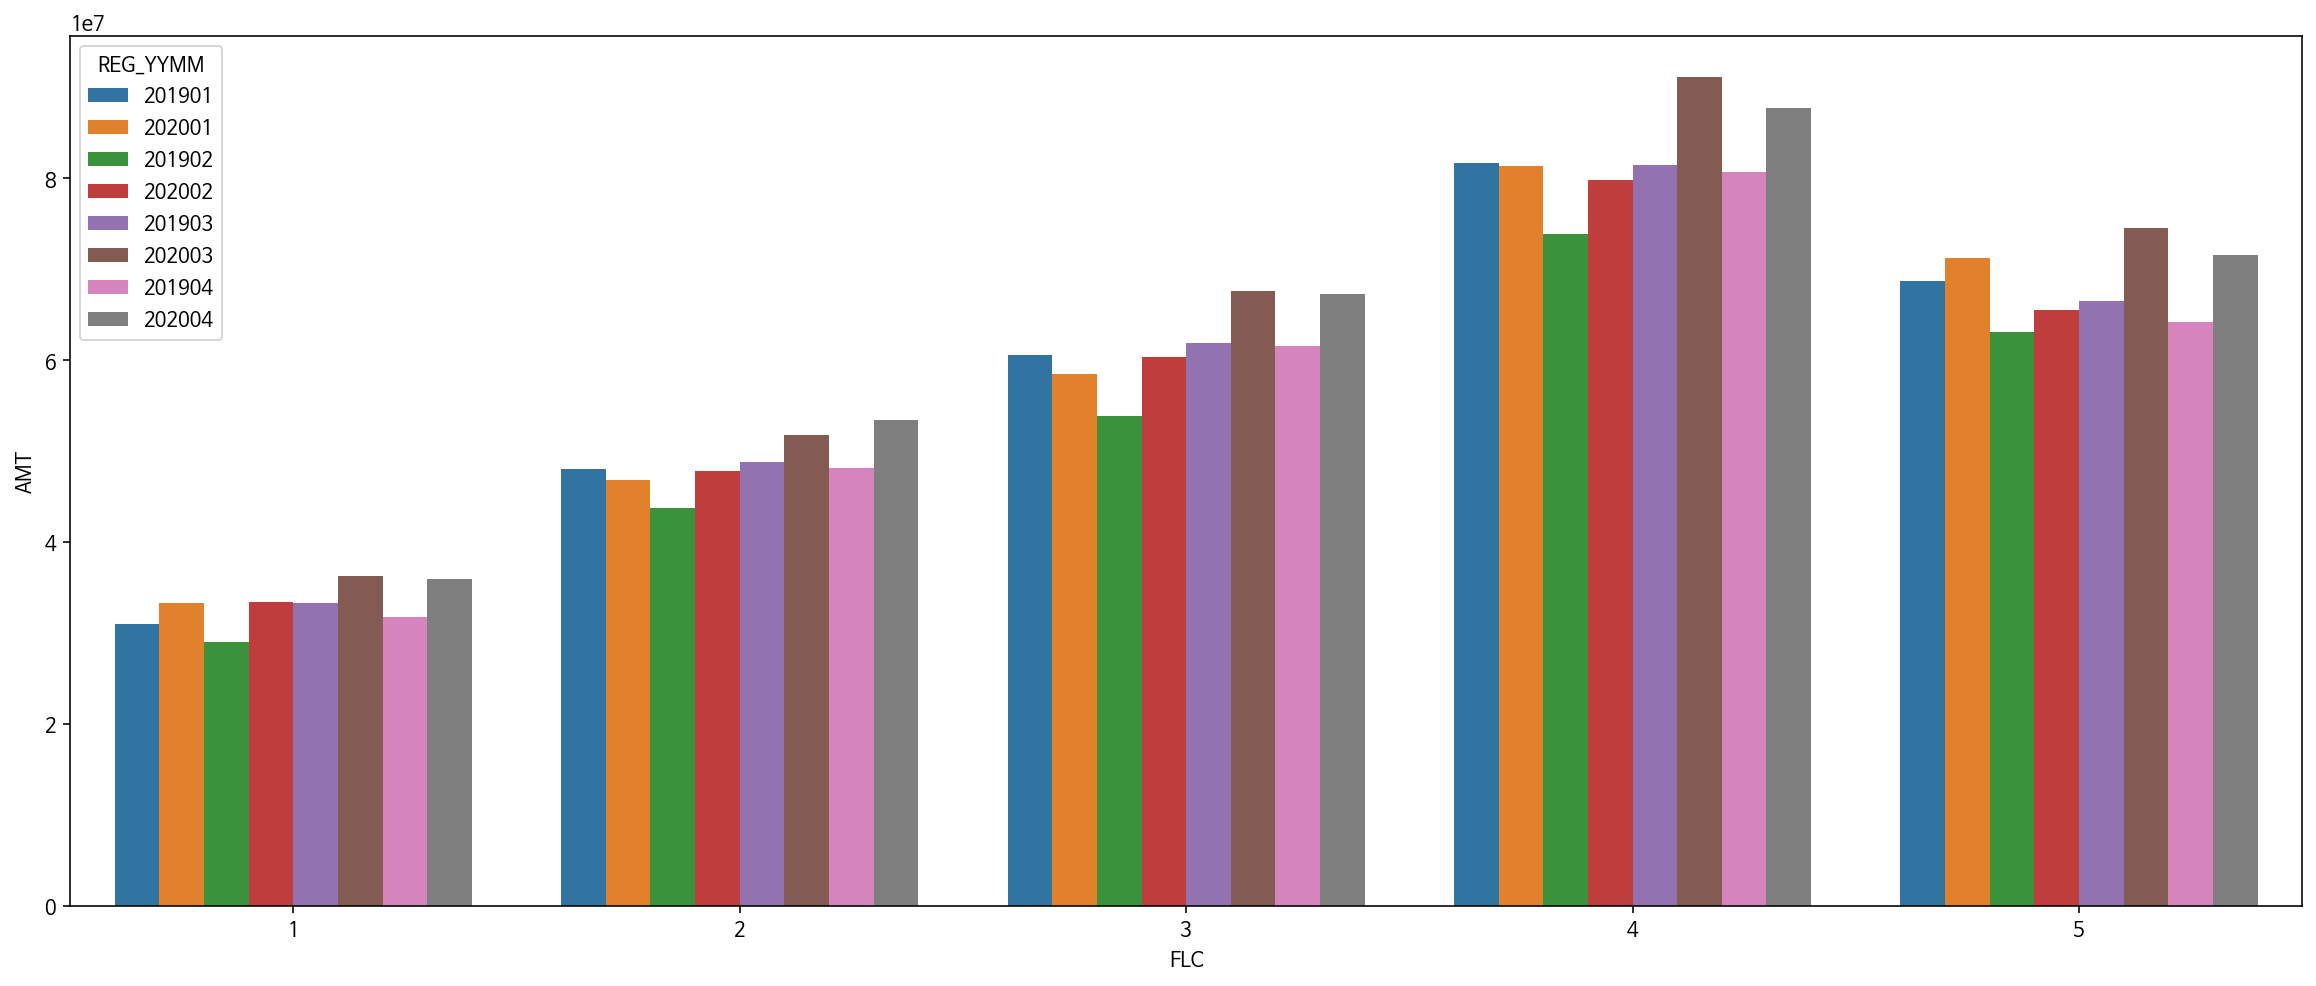

In [ ]:
# 6. 생애주기별 총매출 차이
plt.figure(figsize=(20,8))
sns.barplot(data = row_data_01_04, x = 'FLC', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004], ci = None)

- 생애주기별 매출에서는 생애주기별 다양한 형태로 매출의 모습이 나타난다
- 모델학습에 필요한 피쳐로 판단됨

In [ ]:
# 카드사용지역컬럼과 거주지역컬럼을 이용하여 자신이 살고 있는 지역에서 카드를 사용하였는지 다른지역에서 사용하였는지를 구분하는 컬럼을 생성하고
# 위에서 진행한 EDA와 동일하게 총매출의 차이를 그래프로 그려서 점검

row_data_01_04.loc[row_data_01_04['CARD_SIDO_NM'] == row_data_01_04['HOM_SIDO_NM'], 'MY_HOME'] = 1
row_data_01_04.loc[row_data_01_04['CARD_SIDO_NM'] != row_data_01_04['HOM_SIDO_NM'], 'MY_HOME'] = 0

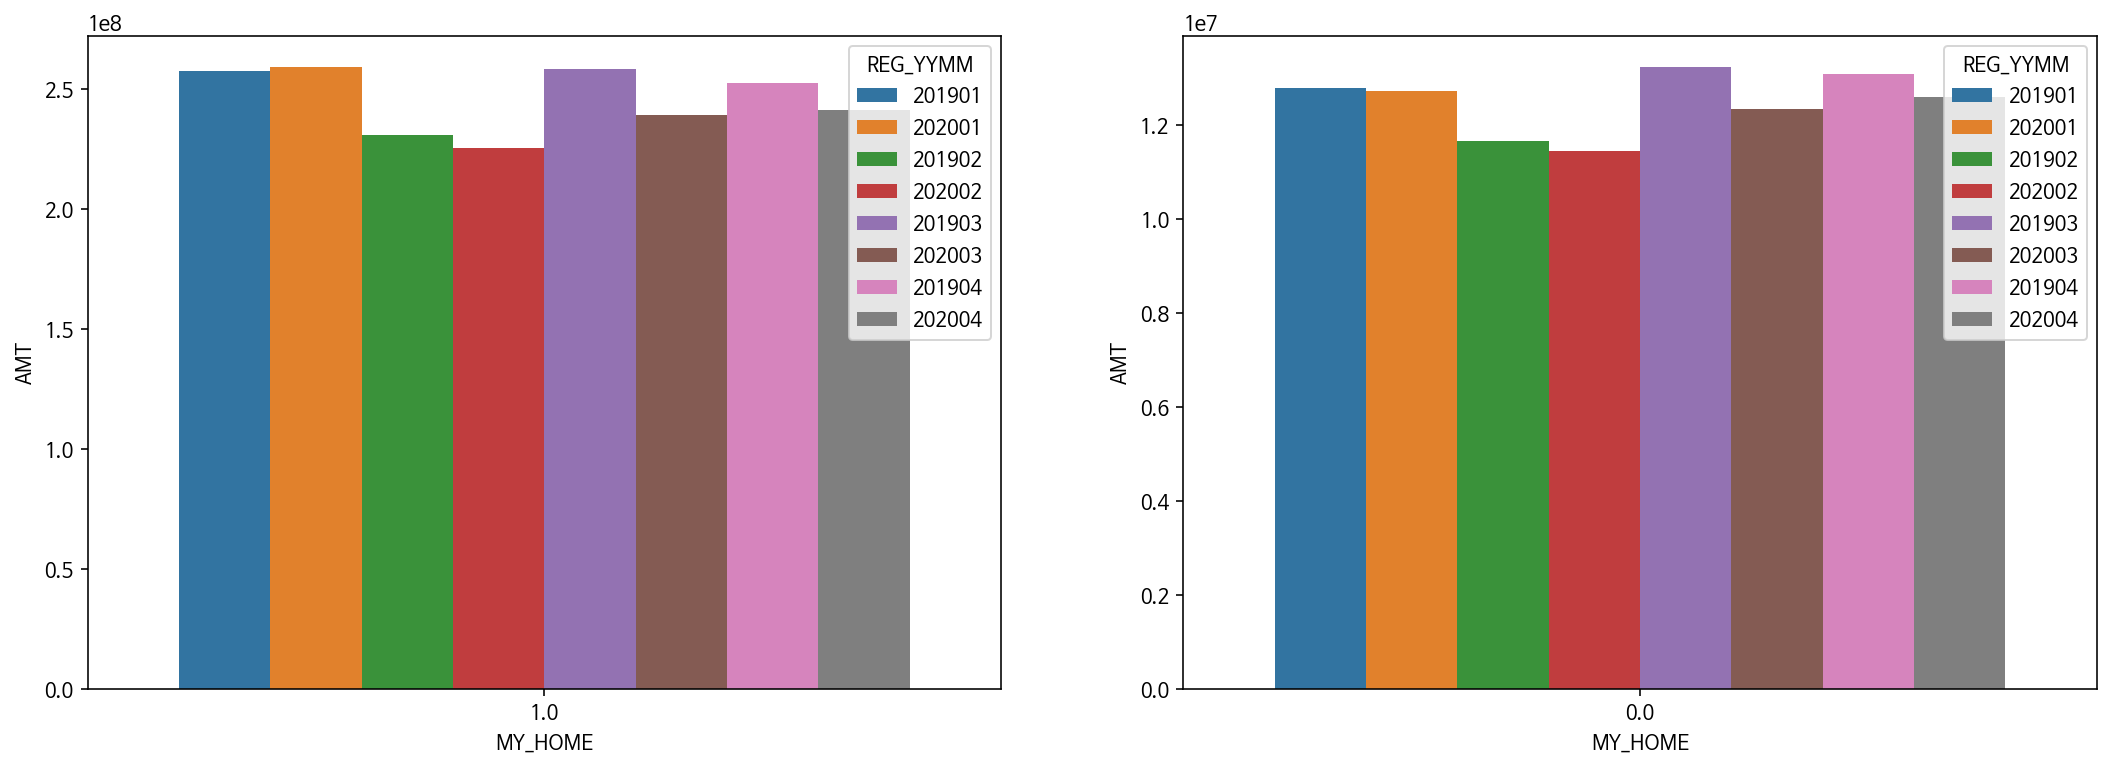

In [ ]:
# 7. 특정 지역 거주자의 카드사용 지역에 따른 총매출 차이

fig,(ax1,ax2)= plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,6)

my_home_plot = row_data_01_04[row_data_01_04['MY_HOME'] == 1]
out_home_plot = row_data_01_04[row_data_01_04['MY_HOME'] == 0]

sns.barplot(data = my_home_plot, x = 'MY_HOME', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004], ci = None, ax = ax1)
sns.barplot(data = out_home_plot, x = 'MY_HOME', y = 'AMT', hue = 'REG_YYMM', hue_order=[201901,202001,201902,202002,201903,202003,201904,202004], ci = None, ax = ax2)

- 사용자의 거주지역과 카드 사용지역이 같고 다름에 따른 매출을 비교하여 보면 당연하게도 거주지역에서 카드를 사용하는 매출액이 훨씬 높기때문에 그래프를 따로 구분하여 그려서 살펴보았다
- 또한 총매출의 모습이 거주지역 에서 카드를 사용하던 아닌던 상관없이 비슷한 양상을 보인다
- 미묘한 차이기는 하나 1월과 나머지 달의 차이가 존재하므로 이것또한 모델학습에 필요한 피쳐로 판단됨

### Feature Enginnering

In [ ]:
# 모델 학습을 위한 데이터 선택 : 2019년 1월/2월/3월/4월/7월 + 2020년 1월/2월/3월/4월 
data2019_12347_2020_1234 = row_data[(row_data['REG_YYMM'] == 201901) | (row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201903) | (row_data['REG_YYMM'] == 201904) | (row_data['REG_YYMM'] == 201907) |
                                    (row_data['REG_YYMM'] == 202001) | (row_data['REG_YYMM'] == 202002) | (row_data['REG_YYMM'] == 202003) | (row_data['REG_YYMM'] == 202004)]
data2019_12347_2020_1234.tail()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
26048109,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
26048110,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
26048111,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
26048112,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7
26048113,202004,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4


In [ ]:
# 년/월 데이터 구분 컬럼 생성을 위한 함수 정의
def grap_year(data):
  data = str(data)
  return int(data[:4])

def grap_month(data):
  data = str(data)
  return int(data[4:])

In [ ]:
# 날짜 처리(년/월 컬럼 분리하여 추가 생성 및 기존 REG_YYMM 컬럼 제거)
temp_data = data2019_12347_2020_1234.copy()
temp_data = temp_data.fillna('')
temp_data['year'] = temp_data['REG_YYMM'].apply(lambda x : grap_year(x))
temp_data['month'] = temp_data['REG_YYMM'].apply(lambda x : grap_month(x))
temp_data = temp_data.drop(['REG_YYMM'], axis = 1)
print(temp_data.shape)
temp_data.tail()

(13869680, 13)


,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
26048109,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5,2020,4
26048110,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6,2020,4
26048111,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5,2020,4
26048112,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7,2020,4
26048113,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4,2020,4


In [ ]:
# 데이터 정제(사용할 컬럼들과 사용하지 않을 컬럼들을 구분하여 변수 설정)
df = temp_data.copy()

df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM','CSTMR_CNT', 'CNT'], axis = 1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD',	'FLC', 'year',	'month']

df = df.groupby(columns).sum().reset_index(drop=False)

print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600409 entries, 0 to 600408
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CARD_SIDO_NM  600409 non-null  object
 1   STD_CLSS_NM   600409 non-null  object
 2   HOM_SIDO_NM   600409 non-null  object
 3   AGE           600409 non-null  object
 4   SEX_CTGO_CD   600409 non-null  int64 
 5   FLC           600409 non-null  int64 
 6   year          600409 non-null  int64 
 7   month         600409 non-null  int64 
 8   AMT           600409 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 41.2+ MB
None
(600409, 9)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,311200
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,605000
2,강원,건강보조식품 소매업,강원,20s,1,1,2020,1,168500
3,강원,건강보조식품 소매업,강원,20s,1,1,2020,3,427510
4,강원,건강보조식품 소매업,강원,20s,1,1,2020,4,478500


In [ ]:
# MY_HOME 피쳐 생성
df.loc[df['CARD_SIDO_NM'] == df['HOM_SIDO_NM'], 'MY_HOME'] = 1
df.loc[df['CARD_SIDO_NM'] != df['HOM_SIDO_NM'], 'MY_HOME'] = 0
df['MY_HOME'] = df['MY_HOME'].astype(int)
df = df[['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE', 'SEX_CTGO_CD', 'FLC', 'year',	'month', 'MY_HOME' ,'AMT']]
print(df.shape)
df.tail()

(600409, 10)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,AMT
600404,충북,휴양콘도 운영업,충북,70s,1,5,2020,2,1,301700
600405,충북,휴양콘도 운영업,충북,70s,2,5,2019,1,1,103400
600406,충북,휴양콘도 운영업,충북,70s,2,5,2019,2,1,83000
600407,충북,휴양콘도 운영업,충북,70s,2,5,2019,3,1,148000
600408,충북,휴양콘도 운영업,충북,70s,2,5,2020,1,1,230400


In [ ]:
# 인코딩(범주형 데이터를 숫자로 변환하는 과정)
dtypes = df.dtypes
encoders = {}

for column in df.columns:
  if str(dtypes[column]) == 'object':
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

df_num = df.copy()
for column in encoders.keys():
  encoder = encoders[column]
  df_num[column] = encoder.transform(df[column])

print(df_num.info())
print(df.shape)
df_num.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600409 entries, 0 to 600408
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   CARD_SIDO_NM  600409 non-null  int64
 1   STD_CLSS_NM   600409 non-null  int64
 2   HOM_SIDO_NM   600409 non-null  int64
 3   AGE           600409 non-null  int64
 4   SEX_CTGO_CD   600409 non-null  int64
 5   FLC           600409 non-null  int64
 6   year          600409 non-null  int64
 7   month         600409 non-null  int64
 8   MY_HOME       600409 non-null  int64
 9   AMT           600409 non-null  int64
dtypes: int64(10)
memory usage: 45.8 MB
None
(600409, 10)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,AMT
600404,16,40,16,6,1,5,2020,2,1,301700
600405,16,40,16,6,2,5,2019,1,1,103400
600406,16,40,16,6,2,5,2019,2,1,83000
600407,16,40,16,6,2,5,2019,3,1,148000
600408,16,40,16,6,2,5,2020,1,1,230400


- 이번 대회의 데이터는 CSTMR_CNT, AMT, CNT를 제외한 모든 피쳐들이 범주형 데이터로써 예측을 하기 위해 모든 피쳐의 조합 경우의수로 구성된 탬플릿을 생성하여 예측하여야함
- 그러나 모델에 학습시킬때 주어진 데이터는 모든 피쳐들 조합의 경우의 수보다 턱없이 부족하므로 우선 모든 조합을 반영한 탬플릿을 생성한 뒤 원본 데이터와 merge를 진행하여 템플릿을 생성하고 원본데이테에 없는 경우의 수들의 빈값은 0으로 채워줌
- 이렇게 생성된 템플릿을 이용하여 모델 학습 진행 한다면 좀더 효과적인 모델링이 가능할것이라 판단됨


In [ ]:
# 학습데이터 탬플릿은 2019년과 2020년을 구분하여 생성한뒤 합침

# 2019년 1월/2월/3월/4월/7월 데이터 템플릿
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2019]
months        = [1,2,3,4,7]

temp_2019 = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
  for STD_CLSS_NM in STD_CLSS_NMs:
    for HOM_SIDO_NM in HOM_SIDO_NMs:
      for AGE in AGEs:
        for SEX_CTGO_CD in SEX_CTGO_CDs:
          for FLC in FLCs:
            for year in years:
              for month in months:
                temp_2019.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp_2019 = np.array(temp_2019)
temp_2019 = pd.DataFrame(data=temp_2019, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month'])
temp_2019.loc[temp_2019['CARD_SIDO_NM'] == temp_2019['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp_2019.loc[temp_2019['CARD_SIDO_NM'] != temp_2019['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp_2019['MY_HOME'] = temp_2019['MY_HOME'].astype(int)

# 2020년 1월/2월/3월/4월 데이터 템플릿
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [1,2,3,4]

temp_2020 = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
  for STD_CLSS_NM in STD_CLSS_NMs:
    for HOM_SIDO_NM in HOM_SIDO_NMs:
      for AGE in AGEs:
        for SEX_CTGO_CD in SEX_CTGO_CDs:
          for FLC in FLCs:
            for year in years:
              for month in months:
                temp_2020.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD,FLC, year, month])
temp_2020 = np.array(temp_2020)
temp_2020 = pd.DataFrame(data=temp_2020, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE','SEX_CTGO_CD', 'FLC', 'year', 'month'])
temp_2020.loc[temp_2020['CARD_SIDO_NM'] == temp_2020['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp_2020.loc[temp_2020['CARD_SIDO_NM'] != temp_2020['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp_2020['MY_HOME'] = temp_2020['MY_HOME'].astype(int)

# df_num 데이터 연도 구분(원본 데이터)
df_num_2019 = df_num[df_num['year'] == 2019]
df_num_2020 = df_num[df_num['year'] == 2020]

print(df_num_2019.shape)
print(df_num_2020.shape)
print(temp_2019.shape)
print(temp_2020.shape)

(356054, 10)
(244355, 10)
(4147150, 9)
(3317720, 9)


In [ ]:
# 2019년과 2020년의 원본데이터와 모든경우의수로 만든 템플릿을 합쳐 준뒤 2019년 2020년 데이터 합치기
# 템플릿과 비교하여 df_num에 없는 데이터 채워주기
data_2019 = pd.merge(temp_2019,
                     df_num_2019,
                     how = 'outer',
                     left_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC','year', 'month',	'MY_HOME'],
                     right_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year',	'month',	'MY_HOME']
                    )

data_2020 = pd.merge(temp_2020,
                     df_num_2020,
                     how = 'outer',
                     left_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year',	'month',	'MY_HOME'],
                     right_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE', 'SEX_CTGO_CD', 'FLC', 'year',	'month',	'MY_HOME']
                    )

data = pd.concat([data_2019, data_2020]).reset_index(drop = True).fillna(0)
print(data.shape)
data

(7464870, 10)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,AMT
0,0,0,0,1,1,1,2019,1,1,311200.0
1,0,0,0,1,1,1,2019,2,1,605000.0
2,0,0,0,1,1,1,2019,3,1,0.0
3,0,0,0,1,1,1,2019,4,1,0.0
4,0,0,0,1,1,1,2019,7,1,0.0
...,...,...,...,...,...,...,...,...,...,...
7464865,16,30,14,0,2,4,2020,4,0,0.0
7464866,16,30,14,0,2,5,2020,1,0,0.0
7464867,16,30,14,0,2,5,2020,2,0,0.0
7464868,16,30,14,0,2,5,2020,3,0,0.0


### Initial Modeling

In [ ]:
# 모델 학습 및 예측을 진행하기에 앞서 학습데이터의 문제와 정답 데이터 분리하기
train = data.sample(frac = 1, random_state = 0)
X_train = train.drop(['AMT'], axis = 1)
y_train = np.log1p(train['AMT'])

### Cross validation

In [ ]:
# 최종모델을 선택하고 사용할 피쳐를 선택하기에 앞서 cross validation을 통해 어떠한 경우가 가장 좋은 성능을 내는지 판단하는 과정
def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    difference = log_predict - log_actual
    difference = np.square(difference)
    mean_difference = difference.mean()
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)

validation_model = ExtraTreesRegressor(n_jobs = -1, random_state = 4)
cv = KFold(5, shuffle=True, random_state=4)
scores = cross_val_score(validation_model, X_train, y_train, cv=cv, scoring=rmsle_scorer)

print("교차 검증 점수: {}". format(scores))
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))

교차 검증 점수: [0.76084291 0.75967729 0.75730498 0.75899611 0.75717497]
교차 검증 평균 점수: 0.76


- 우선 사용을 시도해볼 모델들은 후보는 RamdomForestregressor/ExtraTreeregressor/Linearregressor/LGBMregressor 등을 사용하여 4월 public score 적용시 ExtraTreeregressor의 성능이 가장 좋게 나왔으므로 7월 예측모델은 ExtraTreeregressor 사용을 확정하고 진행함

- 1/2/3/4/7 + 1/2/3/4 + 모든 컬럼사용 : 코랩 메모리 초과로 확인불가
- 1/2/3/4/7 + 1/2/3/4 + 성별제외 : 교차 검증 평균 점수: 0.42
- 1/2/3/4/7 + 1/2/3/4 + 연령제외 : 교차 검증 평균 점수: 0.76
- 1/2/3/4/7 + 1/2/3/4 + 생애주기제외 : 교차 검증 평균 점수 : 0.70
------------------------------------------------------------------
- 2/3/4/7 + 2/3/4 + 모든 컬럼사용 : 교차 검증 평균 점수: 0.41
- 2/3/4/7 + 2/3/4 + 성별제외 : 교차 검증 평균 점수: 0.43
- 2/3/4/7 + 2/3/4 + 연령제외 : 교차 검증 평균 점수: 0.77
- 2/3/4/7 + 2/3/4 + 생애주기제외 : 교차 검증 평균 점수 : 0.71

### 크로스벨리데이션 결과 CARD_CCG_NM, HOM_CCG_NM,CSTMR_CNT,CNT'를 제외한 모든 컬럼을 사용하고 2019년 1월/2월/3월/4월/7월 + 2020년 1월/2월/3월/4월을 사용하였을때 가장 좋은 검증 점수가 나오는 것으로 판단 , 다만 1/2/3/4/7 + 1/2/3/4 + 모든 컬럼사용 시 코랩 메모리 초과로 cross validation을 계산하지 못하였으나 1월을 제외하고 했을 경우도 모든 컬럼이 가장 좋은 성능 보였기에 1월을 추가하였을때도 가장좋은 성능을 보일것이라 판단함

### Model Tuning & Evaluation

In [ ]:
# 모델학습
model = ExtraTreesRegressor(n_jobs = -1, random_state = 4)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=4, verbose=0, warm_start=False)

### Conclusion & Discussion

In [ ]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4,7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                              temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=X_train.columns[:8])
temp.loc[temp['CARD_SIDO_NM'] == temp['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp.loc[temp['CARD_SIDO_NM'] != temp['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp['MY_HOME'] = temp['MY_HOME'].astype(int)

print(temp.shape)
temp.head()

(1658860, 9)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME
0,0,0,0,1,1,1,2020,4,1
1,0,0,0,1,1,1,2020,7,1
2,0,0,0,1,1,2,2020,4,1
3,0,0,0,1,1,2,2020,7,1
4,0,0,0,1,1,3,2020,4,1


In [ ]:
# 예측
predict = model.predict(temp)
predict = np.expm1(predict)
temp['AMT'] = np.round(predict, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,0,0,8.882399e+07
1,202004,0,1,4.708347e+09
2,202004,0,2,1.121029e+09
3,202004,0,3,1.436078e+07
4,202004,0,4,0.000000e+00
...,...,...,...,...
1389,202007,16,36,1.447475e+09
1390,202007,16,37,1.894076e+10
1391,202007,16,38,1.402786e+07
1392,202007,16,39,4.517222e+08


In [ ]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
# 제출 파일 만들기
submission = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.fillna(0)
submission.to_csv('/gdrive/My Drive/data_analysis/jeju/submission_final.csv', encoding='utf-8-sig')
submission

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.882399e+07
1,202004,강원,골프장 운영업,4.708347e+09
2,202004,강원,과실 및 채소 소매업,1.121029e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.436078e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.447475e+09
1390,202007,충북,한식 음식점업,1.894076e+10
1391,202007,충북,호텔업,1.402786e+07
